# 1. Import Libraries

In [1]:
# Tools
import os
import pandas as pd
import numpy as np
from tqdm import trange
from collections import defaultdict
from scipy import stats
import scipy
import pickle
#from parabolic import parabolic
import math


# Audio file processing
import librosa
from librosa import feature
import librosa.display
from IPython.display import Audio
import IPython
from pydub import AudioSegment

# Visual
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,MinMaxScaler,MultiLabelBinarizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# 2. Dataset Description & Background Info

### RAVDESS Dataset

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) - [Link](https://zenodo.org/record/1188976#.XTod4S2ZO3U)-Directly download the dataset from the website
  * The RAVDESS contains 7356 files. Each file was rated 10 times on emotional validity, intensity, and genuineness. Ratings were provided by 247 individuals who were characteristic of untrained adult research participants from North America. A further set of 72 participants provided test-retest data. High levels of emotional validity, interrater reliability, and test-retest intrarater reliability were reported. 
  * Filename identifiers 

    * Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    * Vocal channel (01 = speech, 02 = song).
    * Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    * Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    * Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    * Repetition (01 = 1st repetition, 02 = 2nd repetition).
    * Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

### TESS Dataset

Toronto emotional speech set (TESS) - [Link](https://tspace.library.utoronto.ca/handle/1807/24487) - Use "download_tess_dataset.ipynb" scraper to download the data  
* These stimuli were modeled on the Northwestern University Auditory Test No. 6 (NU-6; Tillman & Carhart, 1966). 
* A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions
    * (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). 
* There are 2800 stimuli in total.
* Two actresses were recruited from the Toronto area. Both actresses speak English as their first language, are university educated, and have musical training. Audiometric testing indicated that both actresses have thresholds within the normal range.

#### Citation

"[The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)](https://zenodo.org/record/1188976)" by Livingstone & Russo is licensed under [CC BY-NA-SC 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).

### Background Info

[Feature Engineering Tools](https://musicinformationretrieval.com/index.html)  
[Imbalanced Class Literature](https://www.svds.com/learning-imbalanced-classes/)  
[MFCC Explanation](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)
* If we just want to classify some sound, we should build features that are speaker independent. Any feature that only gives information about the speaker (like the pitch of their voice) will not be helpful for classification. In other words, we should extract features that depend on the "content" of the audio rather than the nature of the speaker. Also, a good feature extraction technique should mimic the human speech perception. We don't hear loudness on a linear scale. If we want to double the perceived loudness of a sound, we have to put 8 times as much energy into it. Instead of a linear scale, our perception system uses a log scale. Taking these things into account, Davis and Mermelstein came up with MFCC in the 1980's. MFCC mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics. The underlying mathematics is quite complicated and we will skip that. For those interested, here is the detailed explanation.  

[MFCC Librosa Implementation](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html)  
[Sound Augmentation - Kaggle](https://www.kaggle.com/huseinzol05/sound-augmentation-librosa)  
[Fourier Transformation](https://musicinformationretrieval.com/fourier_transform.html)  
[Frequency Cutoff Based on intelligibility : ~10k Hz](https://www.dpamicrophones.com/mic-university/facts-about-speech-intelligibility)  
[Someone implemented gender classification in Python 2](https://appliedmachinelearning.blog/2017/06/14/voice-gender-detection-using-gmms-a-python-primer/)  
[Voice Normalization Tips : Peak vs RMS](https://www.learndigitalaudio.com/normalize-audio)  
[FFT VS RFFT](https://stackoverflow.com/questions/52387673/what-is-the-difference-between-numpy-fft-fft-and-numpy-fft-rfft/52388007)



# 3. Load Data

### Load RAVDESS

In [2]:
# Load audio file names
data_folder_list = os.listdir('data/')
if '.DS_Store' in data_folder_list:
    data_folder_list.remove('.DS_Store')
data = []
for folder in data_folder_list:
    files = os.listdir('data/'+folder)
    if '.DS_Store' in files:
        files.remove('.DS_Store')
    for file in files:
        data.append('data/'+folder+'/'+file)

# Create pandas dataframe for all files
emotion_mapping = {1:'neutral',2:'calm',3:'happy',4:'sad',5:'angry',6:'fearful',7:'disgust',8:'surprised'}
gender_mapping = {0:'female',1:'male'}
df_ravdess = pd.DataFrame({
                   'filename':data,
                   'dataset':['ravdess']*len(data),
                   'emotion':[int(x.split('-')[2]) for x in data],
                   'emotion_desc':[emotion_mapping[int(x.split('-')[2])] for x in data],
                   'emotion_intensity':[int(x.split('-')[3]) for x in data],
                   'statement':[int(x.split('-')[4]) for x in data],
                   'repetition':[int(x.split('-')[5]) for x in data],
                   'actor':[int(x.split('-')[6].split('.')[0]) for x in data],    
                   'gender' :[gender_mapping[int(x.split('-')[0][-5:-3])%2] for x in data]
                  
                  })


### Load TESS

In [3]:
# Load audio file names
file_list = os.listdir('data_tess/')
if '.DS_Store' in file_list:
    file_list.remove('.DS_Store')
data = []
for file in file_list:
    data.append('data_tess/'+file)

# Create pandas dataframe for all files
emotion_mapping = {'neutral':'neutral','angry':'angry','happy':'happy',
                   'sad':'sad','angry':'angry','fear':'fearful','disgust':'disgust','ps':'surprised'}
gender_mapping = {'OA':'male','OAF':'male','YAF':'female'}
df_tess = pd.DataFrame({
                   'filename':data,
                   'dataset':['tess']*len(data),
                   'gender':[gender_mapping[x.split('/')[1].split('_')[0]] for x in data],
                   'emotion_desc':[emotion_mapping[x.split('/')[1].split('_')[2].split('.')[0]] for x in data]
                  
                  })


### Combine RAVDESS and TESS Dataset

In [4]:
df_combined = pd.concat([df_ravdess[df_tess.columns], df_tess], axis=0).reset_index()
df_combined.drop(['index'],inplace=True,axis=1)

# 4. Data Preprocessing & Feature Engineering

#### Funcionts Needed for Data Preprocessing

In [5]:
# Strip silence at the beginning and end of a signal
def strip(signal, frame_length=512, hop_length=256):

    # Compute RMSE.
    rmse = librosa.feature.rms(signal, frame_length=frame_length, hop_length=hop_length, center=True)
    
    # Identify the first frame index where RMSE exceeds a threshold.
    thresh = 0.001
    frame_index = 0
    while rmse[0][frame_index] < thresh:
        frame_index += 1
        
    # Convert units of frames to samples.
    start_sample_index = librosa.frames_to_samples(frame_index, hop_length=hop_length)
    
    signal = signal[start_sample_index:]    
    signal = np.array(list(signal)[::-1])
    
    # Compute RMSE.
    rmse = librosa.feature.rms(signal, frame_length=frame_length, hop_length=hop_length, center=True)
    
    # Identify the first frame index where RMSE exceeds a threshold.
    thresh = 0.001
    frame_index = 0
    while rmse[0][frame_index] < thresh:
        frame_index += 1
        
    # Convert units of frames to samples.
    start_sample_index = librosa.frames_to_samples(frame_index, hop_length=hop_length)
      
    signal = np.array(signal[start_sample_index:])
    
    # Return the trimmed signal.
    return np.array(list(signal)[::-1])


# Fourier Transformation. Link : https://musicinformationretrieval.com/fourier_transform.html
# It transforms our time-domain signal into the frequency domain. Whereas the time domain expresses our signal as a sequence of samples, the frequency domain expresses our signal as a superposition of sinusoids of varying magnitudes, frequencies, and phase offsets.
def rfft(signal):
    return abs(scipy.fftpack.rfft(abs(signal)))

def rfft_clip(signal,min_freq,max_freq,sr):
    freq = np.fft.rfftfreq(len(signal), d=1./sr)
    return abs(np.fft.rfft((signal)))[(freq>min_freq) & (freq<max_freq)]


def fft(signal):
    return scipy.fft(signal)

# I want to normalize in hope of taking gender out of voice
def normalize(signal):
    return librosa.util.normalize(signal)

def min_max_scale(signal):
    scaler = MinMaxScaler(feature_range=(-1,1))
    return scaler.fit_transform(np.array(signal).reshape(-1,1)).reshape(-1)

def spectral_centroid(signal,sr):
    return librosa.feature.spectral_centroid(signal,sr=sr)[0]

# Get length of voice
def seconds(signal):
    return librosa.get_duration(signal)

# Returns total number of times signal crossed zero. It will return 0 if I removed signal below threshold
def zero_crossings(signal):
    return sum(librosa.zero_crossings(signal))

def freq_from_zero_crossings(signal):
    return zero_crossings(signal)/seconds(signal)

# Bucket_size while not losing information by extracting features : std, mean, max, min
def compress_data_and_extract_features(data,bucket_size):
    data_bucket_std = []
    data_bucket_mean = []
    data_bucket_percentile_0 = []
    data_bucket_percentile_1 = []
    data_bucket_percentile_25 = []
    data_bucket_percentile_50 = []
    data_bucket_percentile_75 = []
    data_bucket_percentile_99 = []
    data_bucket_percentile_100 = []
        
    for j in range(0,data.shape[0],bucket_size):
        data_bucket_std.append(abs(data[j:(j+bucket_size)]).std())
        data_bucket_mean.append(abs(data[j:(j+bucket_size)]).mean())
        holder_percentile=np.percentile(abs(data[j:(j+bucket_size)]),[0, 1,25,50,75, 99, 100])
        data_bucket_percentile_0.append(holder_percentile[0])
        data_bucket_percentile_1.append(holder_percentile[1])
        data_bucket_percentile_25.append(holder_percentile[2])
        data_bucket_percentile_50.append(holder_percentile[3])
        data_bucket_percentile_75.append(holder_percentile[4])
        data_bucket_percentile_99.append(holder_percentile[5])
        data_bucket_percentile_100.append(holder_percentile[6])

    
    return np.array(data_bucket_std+data_bucket_mean+data_bucket_percentile_0+data_bucket_percentile_1+data_bucket_percentile_25+data_bucket_percentile_50+data_bucket_percentile_75+data_bucket_percentile_99+data_bucket_percentile_100)
    #return np.array(data_bucket_std+data_bucket_mean+data_bucket_percentile_90+data_bucket_percentile_99+data_bucket_percentile_100)
def extract_max(pitches,magnitudes, shape):
    new_pitches = []
    new_magnitudes = []
    for i in range(0, shape[1]):
        new_pitches.append(np.max(pitches[:,i]))
        new_magnitudes.append(np.max(magnitudes[:,i]))
    return (new_pitches,new_magnitudes)

#### Perform Datapreprocessing

In [6]:
def df_preprocess(df):
    n_fft = 512
    hop_length = 128
    
    
    stripped = []
    signal_extract = []
    mfcc = []
    rmsed = []
    pitch_list = []
    pitch_mag_list = []
    pitch_stat_from_rms = []
    
    
    for i in trange(len(df['filename'])):
        # Empty holder for data for efficiency memory
        stripped_holder,ffted_holder=[],[]               
        
        
        # Load file as signal & strip the silences at the beginning and at the end
        signal,sr = librosa.load(df['filename'].iloc[i],res_type='kaiser_fast') 
        signal = strip(signal)
        stripped.append(signal)
        
        # Extract From Signal
        signal_extract.append(compress_data_and_extract_features(signal,len(signal)))
        
        
        # Get pitches & Magnitudes
        pitch, magnitude = librosa.core.piptrack(y=signal, sr=22050, n_fft=n_fft, hop_length=hop_length, fmin=50, fmax=380, threshold=0.0001, win_length=None, window='hann', center=True, pad_mode='reflect', ref=None)
        pitches,magnitudes = extract_max(pitch,magnitude,pitch.shape)
        pitches = [x for x in pitches if x>0]
        pitch_list.append(compress_data_and_extract_features(np.array(pitches),len(pitches)))
        pitch_mag_list.append(compress_data_and_extract_features(np.array(magnitudes),len(magnitudes)))
        
        # 20 Mfcc features
        mfcc.append(np.mean(librosa.feature.mfcc(signal, sr=sr),axis=1))
        # Get rms
        rms = librosa.feature.rms(y=signal,frame_length=n_fft,hop_length=hop_length)[0]
        rmsed.append(compress_data_and_extract_features(np.array(rms),len(rms)))
        
        # Get top strongest RMS segments of audio file.
        top_idx = np.argsort(rms)[-30:]
        mean_freq_list = []
        # Iterate through each strong rms segments to extract pitches
        for ix,index in enumerate(top_idx):
            max_rms_frame_start = int(index/len(rms)*len(signal)-n_fft*2)
            max_rms_frame_stop = int(index/len(rms)*len(signal)+n_fft*2)
            audio_strongest_rms = signal[max_rms_frame_start:max_rms_frame_stop]
            # Auto correlate the audio in hope of removing noise and getting fundamental frequencyu
            signal_autocorr = librosa.autocorrelate(audio_strongest_rms)
            # Get pitch and magnitude of each segment
            if list(signal_autocorr):
                pitch_rms, _ = librosa.core.piptrack(y=signal_autocorr, sr=22050, n_fft=n_fft, hop_length=hop_length, fmin=50, fmax=380, threshold=0.0001, win_length=None, window='hann', center=True, pad_mode='reflect', ref=None)
                freq_list_holder = []
                for i in range(len(pitch_rms)):            
                    freq_list_holder+=list(pitch_rms[i])
                mean_freq_list.append(np.mean([x for x in freq_list_holder if x>0])) 
            mean_freq_list = [x for x in mean_freq_list if x>0]
        pitch_stat_from_rms_holder = []
        pitch_stat_from_rms_holder.append(np.mean(mean_freq_list))
        pitch_stat_from_rms_holder.append(np.std(mean_freq_list))
        pitch_stat_from_rms_holder.append(np.min(mean_freq_list))
        pitch_stat_from_rms_holder.append(np.max(mean_freq_list))
        pitch_stat_from_rms.append(np.array(pitch_stat_from_rms_holder))
          
    df['stripped']= stripped
    df['stripped_stat']=signal_extract
    df['mfcc']= mfcc
    df['rmsed']= rmsed
    df['pitch_list']= pitch_list
    df['pitch_mag_list']=pitch_mag_list
    df['pitch_stat_from_rms'] = pitch_stat_from_rms
    return df
# df_combined_processed = df_preprocess(df_combined).copy()
# with open('df_combined_processed_rms_pitch_new.pkl', 'wb') as picklefile:
#     pickle.dump(df_combined_processed, picklefile)

# 5. Modeling

### Confusion Matrix  & Scoring Functions

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    SMALL_SIZE = 8
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 20

    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
 
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def various_scores_string_binary(model,X,y,data_type):
    pred = model.predict(X)
    binarizer = MultiLabelBinarizer()
    binarizer.fit(y)

    print(data_type," Data")
    print("Accuracy : {:.2f} %".format(metrics.accuracy_score(binarizer.transform(y),binarizer.transform(pred))*100))
    print("Precision : {:.2f}".format(metrics.precision_score(binarizer.transform(y),binarizer.transform(pred),average='macro')))
    print("Recall : {:.2f}".format(metrics.recall_score(binarizer.transform(y),binarizer.transform(pred),average='macro')))
    print("F1 : {:.2f}".format(metrics.f1_score(binarizer.transform(y),binarizer.transform(pred),average='macro')))
    
def various_scores(model,X,y,data_type):
    pred = model.predict(X)
    print(data_type," Data")
    print('######################################################')
    print("Accuracy : {:.2f} %".format(metrics.accuracy_score(y, pred)*100))
    print('______________________________________________________')
    print(metrics.classification_report(y,pred,digits=2))
    print('______________________________________________________')   
    

## Gender Classification

#### Train, Validation, Test Split

In [9]:
# df_combined_processed_30_10000.pkl   df_combined_processed_30_300_norm.pkl    df_combined_processed_rms_pitch.pkl
with open('df_combined_processed_rms_pitch_new_mac.pkl', 'rb') as picklefile: 
    df_combined_processed = pickle.load(picklefile)

In [10]:
X_pitch_stat = pd.DataFrame(list(df_combined_processed['pitch_stat_from_rms']))
X_pitch_stat.columns = ['pitch_mean','pitch_std','pitch_min','pitch_max']
X_pitch_extract = pd.DataFrame(list(df_combined_processed['pitch_list']))
X_pitch_extract.columns = ['pitch_extract_std','pitch_extract_mean','pitch_extract_0th','pitch_extract_1st','pitch_extract_25th','pitch_extract_50th','pitch_extract_75th','pitch_extract_99th','pitch_extract_100th']
X_pitch_mag_extract = pd.DataFrame(list(df_combined_processed['pitch_mag_list']))
X_pitch_mag_extract.columns = ['pitch_mag_extract_std','pitch_mag_extract_mean','pitch_mag_extract_0th','pitch_mag_extract_1st','pitch_mag_extract_25th','pitch_mag_extract_50th','pitch_mag_extract_75th','pitch_mag_extract_99th','pitch_mag_extract_100th']
X_rms_extract = pd.DataFrame(list(df_combined_processed['rmsed']))
X_rms_extract.columns = ['rms_extract_std','rms_extract_mean','rms_extract_0th','rms_extract_1st','rms_extract_25th','rms_extract_50th','rms_extract_75th','rms_extract_99th','rms_extract_100th']
X_mfcc = pd.DataFrame(list(df_combined_processed['mfcc']))
X_mfcc.columns=['mfcc_1','mfcc_2','mfcc_3','mfcc_4','mfcc_5','mfcc_6','mfcc_7','mfcc_8','mfcc_9','mfcc_10','mfcc_11','mfcc_12','mfcc_13','mfcc_14','mfcc_15','mfcc_16','mfcc_17','mfcc_18','mfcc_19','mfcc_20']



df_multiple_features = pd.concat([X_pitch_stat,X_pitch_extract], axis=1)

# For X, choose one of the three dataframe at the top
X = df_multiple_features
y_gender = pd.DataFrame({'gender':np.array(df_combined_processed['gender'])})
df_X_y = pd.concat([X,y_gender], axis=1)
df_X_y.dropna(inplace=True)
y_gender = df_X_y['gender']
X = df_X_y.drop(['gender'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y_gender, test_size=0.2,random_state=209)


### LightGBM - RandomizedSearchCV

In [11]:
#Define hyperparameters for GridSearchCV & RandomizedSearchCV
scoring_list = ['accuracy', 'balanced_accuracy','f1_micro','f1_macro','f1_weighted']
hyperparameters = {'polynomial__degree':[1],
                   'model__boosting_type':['gbdt'],#gbdt, gbrt, rf, random_forest, dart, goss
                   #'model__class_weight':[],
                   #'model__colsample_bytree':[0.33,0.66,1],
                   #'model__importance_type':[],
                   #'model__learning_rate':[0.01],
                   'model__max_depth':[-1,3,4,5,6],
                   'model__min_child_samples':[10,20,40], # Default 20
                   #'model__min_child_weight':[0.001], # Default 0.001
                   #'model__min_split_gain':[0], # Default 0
                   #'model__n_estimators':[100], # Default 100
                   #'model__n_jobs':[0], # Default 0. Num_threads
                   'model__num_leaves':[6,15,31,62], # Default 31
                   'model__objective':['binary'],
                   'model__random_state':[209],
                   'model__reg_alpha':[0,0.5,1], # Default 0
                   'model__reg_lambda':[0,0.5,1] # Default 0
                   #'model__silent':[], # No info
                   #'model__subsample':[1], # Default 1
                   #'model__subsample_for_bin':[], # Default 200000
                   #'model__subsample_freq':[0], # Default 0
                   
                   }
lgbm_grid_gender = RandomizedSearchCV(estimator=LGBMClassifier(),
                             param_distributions=hyperparameters,
                             cv=5,
                             random_state=209,
                             scoring=scoring_list[3],
                             #n_iter=10,
                             verbose=1)
lgbm_grid_gender.fit(X_train,y_train)

# Save Trained Model
with open('lgbm_grid_gender.pkl', 'wb') as picklefile:
    pickle.dump(lgbm_grid_gender, picklefile)

print(lgbm_grid_gender.best_params_)
print('______________________')
various_scores_string_binary(lgbm_grid_gender,X_train,y_train,'Train')
print('______________________')
various_scores_string_binary(lgbm_grid_gender,X_test,y_test,'Test')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    9.6s finished


{'polynomial__degree': 1, 'model__reg_lambda': 0, 'model__reg_alpha': 0, 'model__random_state': 209, 'model__objective': 'binary', 'model__num_leaves': 62, 'model__min_child_samples': 10, 'model__max_depth': 6, 'model__boosting_type': 'gbdt'}
______________________
Train  Data
Accuracy : 99.50 %
Precision : 1.00
Recall : 1.00
F1 : 1.00
______________________
Test  Data
Accuracy : 86.20 %
Precision : 0.97
Recall : 0.97
F1 : 0.97


#### Real Test

In [12]:
formats_to_convert = ['.m4a']
# test_data youtube_test
folder = "test_data/"

for (dirpath, dirnames, filenames) in os.walk(folder):
    for filename in filenames:
        if filename.endswith(tuple(formats_to_convert)):

            filepath = dirpath + '/' + filename
            (path, file_extension) = os.path.splitext(filepath)
            file_extension_final = file_extension.replace('.', '')
            try:
                track = AudioSegment.from_file(filepath,
                        file_extension_final)
                wav_filename = filename.replace(file_extension_final, 'wav')
                wav_path = dirpath + '/' + wav_filename
                print('CONVERTING: ' + str(filepath))
                file_handle = track.export(wav_path, format='wav')
                os.remove(filepath)
            except:
                print("ERROR CONVERTING " + str(filepath))
def process_test_data():
    # Load files to test
    test_data_folder_list = os.listdir(folder)
    if '.DS_Store' in test_data_folder_list:
        test_data_folder_list.remove('.DS_Store')
    test_data_folder_list = [folder+x for x in test_data_folder_list]

    # Create dataframe for test data
    df_test = pd.DataFrame({'filename':test_data_folder_list})

    # Process df_test and create ffted,mfcc,and etc...
    df_test_processed = df_preprocess(df_test)

    X_test_pitch_stat = pd.DataFrame(list(df_test_processed['pitch_stat_from_rms']))
    X_test_pitch_extract = pd.DataFrame(list(df_test_processed['pitch_list']))
    X_test_pitch_mag_extract = pd.DataFrame(list(df_test_processed['pitch_mag_list']))
    X_test_rms_extract = pd.DataFrame(list(df_test_processed['rmsed']))
    X_test_mfcc = pd.DataFrame(list(df_test_processed['mfcc']))

    df_test_multiple_features = pd.concat([X_test_pitch_stat,X_test_pitch_extract], axis=1)

    # For X_real_test, choose one of the top
    test_gender = df_test_multiple_features.dropna()
    test_class = X_test_mfcc
    return test_gender,test_class,df_test_processed

def predict_gender_and_emotion(model_gender,data_gender,df_test_processed):
    pred_gender = model_gender.predict(data_gender)
    pred_gender_proba = model_gender.predict_proba(data_gender)
    for i in range(len(df_test_processed)):
        print('{}[{}] : {}'.format(pred_gender[i],pred_gender_proba[i],df_test_processed['filename'][i].split('/')[1].split('.')[0]))
        IPython.display.display(Audio(df_test_processed['stripped'][i],rate=22050))
        print('____________________')
test_gender,test_class,df_test_processed = process_test_data()
predict_gender_and_emotion(lgbm_grid_gender,test_gender,df_test_processed)

100%|██████████| 19/19 [00:09<00:00,  2.23it/s]

female[[0.55935744 0.44064256]] : eva_sad


____________________
male[[0.36810924 0.63189076]] : benson_outlier


____________________
male[[0.01100552 0.98899448]] : low_matt


____________________
male[[0.23225926 0.76774074]] : eva


____________________
female[[0.74120615 0.25879385]] : danielo_wrong


____________________
female[[0.99417127 0.00582873]] : evahappy


____________________
female[[0.96800192 0.03199808]] : youtube


____________________
female[[0.73124913 0.26875087]] : high_matt


____________________
female[[0.81632727 0.18367273]] : eva_sad2


____________________
female[[0.54558084 0.45441916]] : eva2


____________________
female[[0.99802275 0.00197725]] : eva3


____________________
male[[0.2047872 0.7952128]] : danielo_2


____________________
female[[0.67340009 0.32659991]] : eva1


____________________
male[[0.22749023 0.77250977]] : matt1


____________________
female[[0.99163866 0.00836134]] : valentina


____________________
female[[0.9975576 0.0024424]] : female


____________________
male[[0.03863672 0.96136328]] : mick


____________________
female[[0.65995284 0.34004716]] : evaangry


____________________
female[[0.9973576 0.0026424]] : jhonny


____________________


## Emotion Classification - Multiclass

#### Train, Validation, Test Split

In [13]:
with open('df_combined_processed_rms_pitch_new_mac.pkl', 'rb') as picklefile: 
    df_combined_processed = pickle.load(picklefile)

# Based on EDA, we'll combine 'neutral' and 'calm' by converting 'calm' to 'neutral'  
df_combined_processed['emotion_desc']=[x.replace('calm','neutral') for x in list(df_combined_processed['emotion_desc'])]
    
X_pitch_stat = pd.DataFrame(list(df_combined_processed['pitch_stat_from_rms']))
X_pitch_stat.columns = ['pitch_mean','pitch_std','pitch_min','pitch_max']
X_pitch_extract = pd.DataFrame(list(df_combined_processed['pitch_list']))
X_pitch_extract.columns = ['pitch_extract_std','pitch_extract_mean','pitch_extract_0th','pitch_extract_1st','pitch_extract_25th','pitch_extract_50th','pitch_extract_75th','pitch_extract_99th','pitch_extract_100th']
X_pitch_mag_extract = pd.DataFrame(list(df_combined_processed['pitch_mag_list']))
X_pitch_mag_extract.columns = ['pitch_mag_extract_std','pitch_mag_extract_mean','pitch_mag_extract_0th','pitch_mag_extract_1st','pitch_mag_extract_25th','pitch_mag_extract_50th','pitch_mag_extract_75th','pitch_mag_extract_99th','pitch_mag_extract_100th']
X_rms_extract = pd.DataFrame(list(df_combined_processed['rmsed']))
X_rms_extract.columns = ['rms_extract_std','rms_extract_mean','rms_extract_0th','rms_extract_1st','rms_extract_25th','rms_extract_50th','rms_extract_75th','rms_extract_99th','rms_extract_100th']
X_mfcc = pd.DataFrame(list(df_combined_processed['mfcc']))
X_mfcc.columns=['mfcc_1','mfcc_2','mfcc_3','mfcc_4','mfcc_5','mfcc_6','mfcc_7','mfcc_8','mfcc_9','mfcc_10','mfcc_11','mfcc_12','mfcc_13','mfcc_14','mfcc_15','mfcc_16','mfcc_17','mfcc_18','mfcc_19','mfcc_20']



df_multiple_features = pd.concat([X_pitch_stat,X_pitch_extract,X_pitch_mag_extract,X_rms_extract,X_mfcc], axis=1)

# For X, choose one of the three dataframe at the top
X = df_multiple_features
y_class = pd.DataFrame({'emotion_desc':np.array(df_combined_processed['emotion_desc'])})


df_X_y = pd.concat([X,y_class], axis=1)
df_X_y.dropna(inplace=True)
y_class = df_X_y['emotion_desc']
X = df_X_y.drop(['emotion_desc'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2,random_state=209)

### LightGBM - RandomizedSearchCV

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   29.0s finished


Train  Data
######################################################
Accuracy : 99.12 %
______________________________________________________
              precision    recall  f1-score   support

       angry       1.00      0.99      0.99       463
     disgust       0.97      0.99      0.98       472
     fearful       1.00      0.99      0.99       476
       happy       1.00      0.99      1.00       480
     neutral       0.99      1.00      0.99       541
         sad       1.00      0.99      0.99       482
   surprised       0.99      0.99      0.99       478

    accuracy                           0.99      3392
   macro avg       0.99      0.99      0.99      3392
weighted avg       0.99      0.99      0.99      3392

______________________________________________________
Test  Data
######################################################
Accuracy : 84.08 %
______________________________________________________
              precision    recall  f1-score   support

       angry

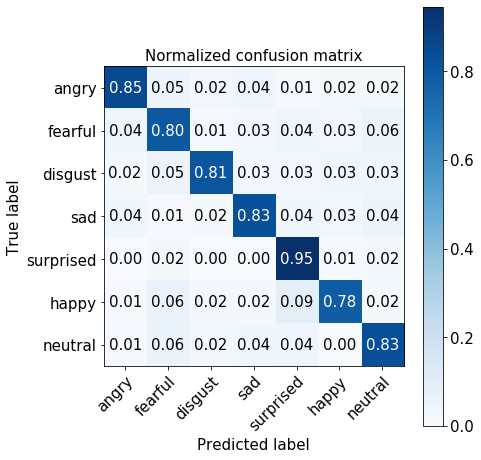

In [14]:
scoring_list = ['accuracy', 'balanced_accuracy','f1_micro','f1_macro','f1_weighted']
hyperparameters = {'boosting_type':['gbdt'],#gbdt, gbrt, rf, random_forest, dart, goss
                   #'model__class_weight':[],
                   #'model__colsample_bytree':[0.33,0.66,1],
                   #'model__importance_type':[],
                   #'model__learning_rate':[0.01],
                   'max_depth':[3,4],
                   'min_child_samples':[10,20,40], # Default 20
                   #'model__min_child_weight':[0.001], # Default 0.001
                   #'model__min_split_gain':[0], # Default 0
                   #'model__n_estimators':[100], # Default 100
                   #'model__n_jobs':[0], # Default 0. Num_threads
                   'num_leaves':[6,15,31,62], # Default 31
                   'objective':['binary'],
                   'random_state':[209],
                   'reg_alpha':[0,0.5,1], # Default 0
                   'reg_lambda':[0,0.5,1] # Default 0
                   #'model__silent':[], # No info
                   #'model__subsample':[1], # Default 1
                   #'model__subsample_for_bin':[], # Default 200000
                   #'model__subsample_freq':[0], # Default 0
                   
                   }
lgbm_grid_class = RandomizedSearchCV(estimator=LGBMClassifier(),
                             param_distributions=hyperparameters,
                             cv=3,
                             random_state=209,
                             scoring=scoring_list[3],
                             #n_iter=10,
                             verbose=1)
lgbm_grid_class.fit(X_train,y_train)

# Save Trained Model
with open('lgbm_grid_class.pkl', 'wb') as picklefile:
    pickle.dump(lgbm_grid_class, picklefile)

lgbm_grid_class.best_params_
various_scores(lgbm_grid_class,X_train,y_train,'Train')
various_scores(lgbm_grid_class,X_test,y_test,'Test')
plot_confusion_matrix((y_test),lgbm_grid_class.predict(X_test),classes=list(df_combined_processed['emotion_desc'].unique()),normalize=True);

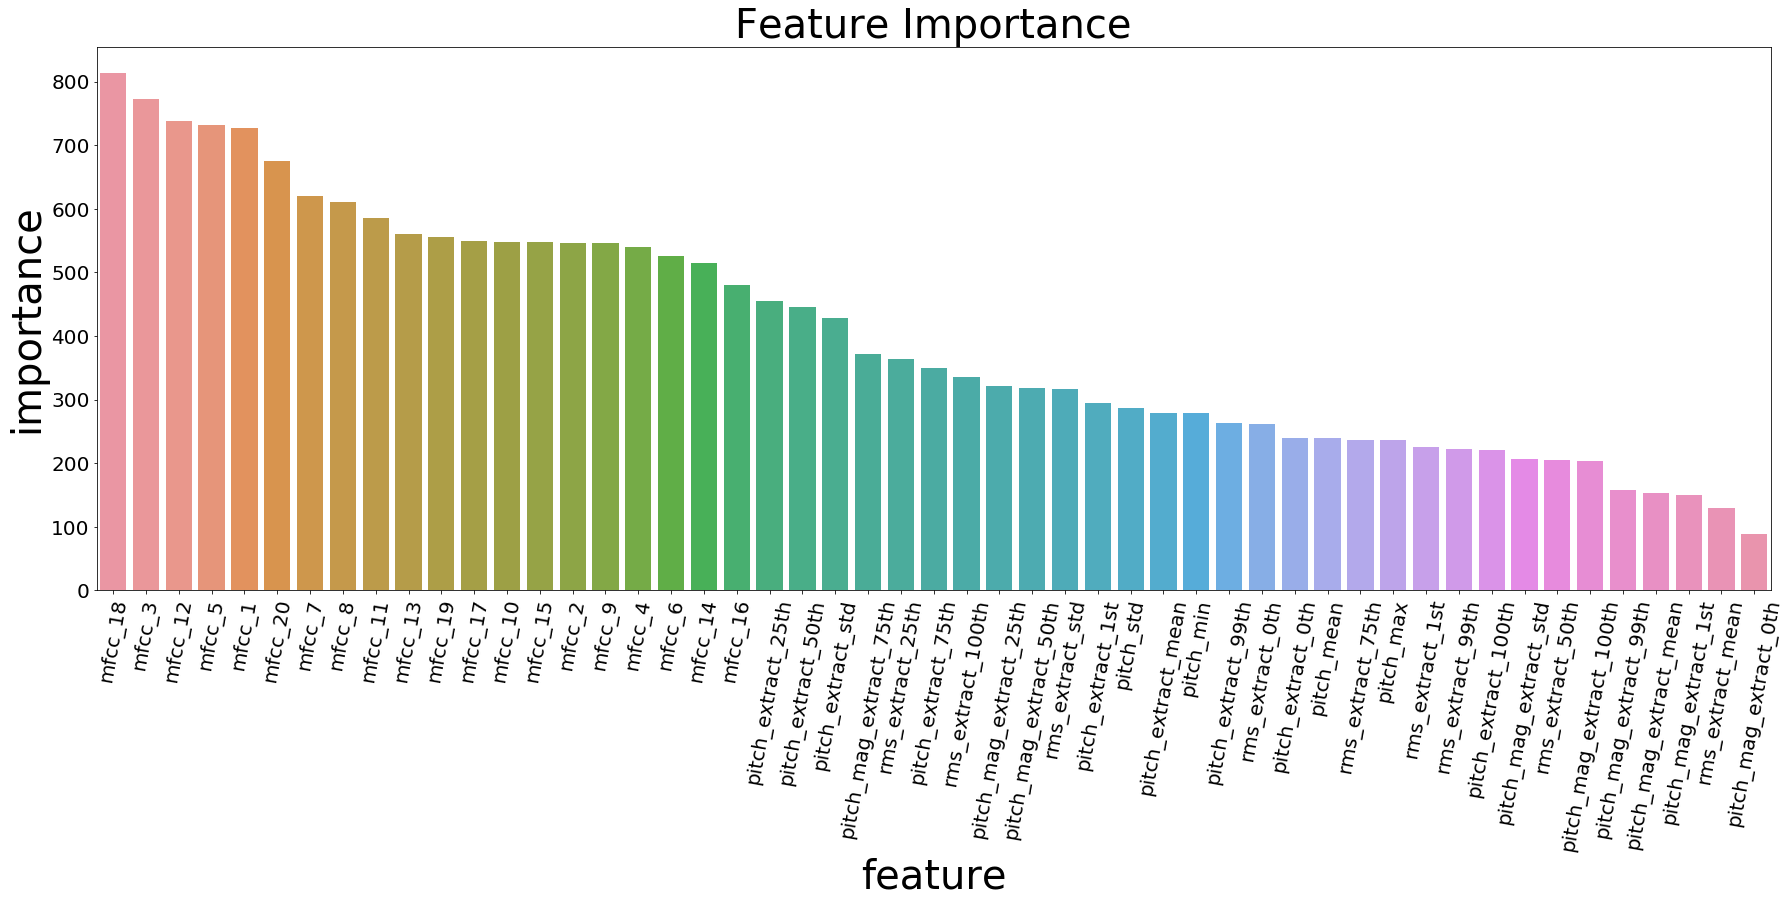

In [73]:
feature_importance = pd.DataFrame({'feature':X.columns,'importance':lgbm_grid_class.best_estimator_.feature_importances_})
feature_importance.sort_values(by='importance',ascending=False,inplace=True)

plt.figure(figsize=(30, 10))

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=40)     # fontsize of the axes title
plt.rc('axes', labelsize=40)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.rc('figure', titlesize=50)  # fontsize of the figure title
plt.title('Feature Importance')
plt.xticks(rotation=80)
sns.barplot(y=feature_importance['importance'],x=feature_importance['feature'])

# 6. Test Model w/ Real World Data (YouTube)

### Convert .m4a to .wav format

In [17]:
formats_to_convert = ['.m4a']

folder = "youtube_test/"

for (dirpath, dirnames, filenames) in os.walk(folder):
    for filename in filenames:
        if filename.endswith(tuple(formats_to_convert)):

            filepath = dirpath + '/' + filename
            (path, file_extension) = os.path.splitext(filepath)
            file_extension_final = file_extension.replace('.', '')
            try:
                track = AudioSegment.from_file(filepath,
                        file_extension_final)
                wav_filename = filename.replace(file_extension_final, 'wav')
                wav_path = dirpath + '/' + wav_filename
                print('CONVERTING: ' + str(filepath))
                file_handle = track.export(wav_path, format='wav')
                os.remove(filepath)
            except:
                print("ERROR CONVERTING " + str(filepath))


### Gender & Emotion Classification

In [19]:
def process_test_data():
    # Load files to test
    test_data_folder_list = os.listdir(folder)
    if '.DS_Store' in test_data_folder_list:
        test_data_folder_list.remove('.DS_Store')
    test_data_folder_list = [folder+x for x in test_data_folder_list]

    # Create dataframe for test data
    df_test = pd.DataFrame({'filename':test_data_folder_list})

    # Process df_test and create ffted,mfcc,and etc...
    df_test_processed = df_preprocess(df_test)

    # Get features from df_test_processed
    X_test_pitch_stat = pd.DataFrame(list(df_test_processed['pitch_stat_from_rms']))
    X_test_pitch_extract = pd.DataFrame(list(df_test_processed['pitch_list']))
    X_test_pitch_mag_extract = pd.DataFrame(list(df_test_processed['pitch_mag_list']))
    X_test_rms_extract = pd.DataFrame(list(df_test_processed['rmsed']))
    X_test_mfcc = pd.DataFrame(list(df_test_processed['mfcc']))
    
    df_test_gender_multiple_features = pd.concat([X_test_pitch_stat,X_test_pitch_extract], axis=1)
    df_test_class_multiple_features = pd.concat([X_test_pitch_stat,X_test_pitch_extract,X_test_pitch_mag_extract,X_test_rms_extract,X_test_mfcc], axis=1)

    # For X_real_test, choose one of the top
    test_gender = df_test_gender_multiple_features
    test_class = df_test_class_multiple_features
    return test_gender,test_class,df_test_processed

def predict_gender_and_emotion(model_gender,model_class,data_gender, data_class,df_test_processed):
    pred_gender = model_gender.predict(data_gender)
    pred_gender_proba = model_gender.predict_proba(data_gender)
    pred_class = []
    for ix in range(len(data_class)):
        pred_class.append(model_class.predict(data_class.iloc[[ix]]))
    for i in range(len(df_test_processed)):
        print('{}[{}] : {} - {}'.format(pred_gender[i],pred_gender_proba[i],pred_class[i],df_test_processed['filename'][i].split('/')[1].split('.')[0]))
        IPython.display.display(Audio(df_test_processed['stripped'][i],rate=22050))
        print('____________________')
        


In [20]:
test_gender,test_class,df_test_processed = process_test_data()
predict_gender_and_emotion(lgbm_grid_gender,lgbm_grid_class,test_gender,test_class,df_test_processed)

100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

female[[0.71259948 0.28740052]] : ['angry'] - crying_woman


____________________
male[[0.24113756 0.75886244]] : ['angry'] - angry_driver


____________________
male[[0.18750958 0.81249042]] : ['angry'] - angry


____________________
male[[0.02294478 0.97705522]] : ['happy'] - sad_cryingcar_woman


____________________
male[[0.01433573 0.98566427]] : ['angry'] - angry_woman


____________________
